## Includes

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import glob
from einops import rearrange
from box import Box

# Latex results

In [69]:
results = [pd.read_csv(path) for path in glob.glob("../../logs/*csv")]
print(len(results))
results = pd.concat(results)
# Clean dataframe
results = results.apply(lambda x: x.apply(lambda y: y.split(' ')[1][:-1]))
results

1293


,eeg_feature,model,hidden_channels,window_size,batch_size,learning_rate,dropout_rate,weight_decay,activation_funct,number_train_samples,...,val_f1,val_prec,val_reca,val_roc,pytorch_total_params,train_time,best_epoch,experiment_id,train_samples,val_samples
0,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8522854690426398,0.872042692918295,0.8603125,0.9867886088709676,16677,3358.1363031864166,1109,'28','349,'342
1,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8322322273253404,0.8401366979143605,0.84375,0.983835181451613,16677,1589.5292069911957,437,'1168','151,'271
2,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.7709894893373543,0.7875152875678328,0.776875,0.982107258064516,16677,2573.179792165756,776,'2308','855,'858
3,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8682450705841627,0.8704146612839095,0.8771875,0.9934779233870967,16677,1182.5789799690247,363,'3448','416,'762
4,'wav','CNN',256,0.25,32,0.0005,0.25,0.0,'relu',2,...,0.8561750756522502,0.8602070431385651,0.8678125000000001,0.98903125,16677,3261.1691002845764,1057,'4588','88,'469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.27963438316453837,0.3813149285106948,0.251875,0.6156347782258065,8417,2006.3740091323853,572,'6563','156,'230
6,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.27749503224576694,0.3898024719547163,0.2578125,0.6127298387096773,8417,1397.7262737751007,352,'8843','373,'281
7,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.307950082333493,0.4474532603764968,0.29500000000000004,0.6686327620967742,8417,1193.5467810630798,290,'9983','252,'364
8,'raw','CNN',128,0.5,32,0.0005,0.25,0.0,'relu',2,...,0.23761364063347176,0.3403170651814279,0.22093749999999998,0.6038013104838711,8417,1500.0500242710114,396,'11123','27,'298


In [84]:
model_names = ['LR','MLP','CNN','GraphConv']
hidden_channels = [512, 1024]
models = list(filter(None, [f'{name}_{hc}' if not name == 'LR' else None if hc != 512 else 'LR' for name in model_names for hc in hidden_channels ]))
features = ['raw']
window_sizes = [0.5]
number_train_samples = [16, 32, 64, 128, 256, 512]

In [85]:
sorted_by_time_nts_ws = np.array([ws*nts for ws in window_sizes for nts in number_train_samples])
b = np.array([ws for ws in window_sizes for nts in number_train_samples])
c = np.array([nts for ws in window_sizes for nts in number_train_samples])
idx = np.argsort(sorted_by_time_nts_ws)
sorted_by_time_nts_ws.sort()
sorted_ws = b[idx]
sorted_nts = c[idx]

In [86]:
df = None
for ef in features:
    df = pd.DataFrame(index=models)
    for (ws,nts) in zip(sorted_ws, sorted_nts):
        res_col = []
        for model in models:
            
            if model == 'LR':
                hc = 0
            else:
                model, hc = model.split('_')
                hc = int(hc)
            res = results[(results['model'] == f'\'{model}\'') & (results['hidden_channels'].astype(int)==hc) & (results['window_size'].astype(float) == ws) & (results['number_train_samples'].astype(int)==nts) & (results['eeg_feature'] == f'\'{ef}\'')]
            mean_acc = res['test_acc'].astype(float).mean()
            std_acc = res['test_acc'].astype(float).std()

            res_col.append(f'{mean_acc:.2f}±{std_acc:.2f}')
        df[f'{ef} {ws}s x{nts}'] = res_col  

In [87]:
df

,raw 0.5s x16,raw 0.5s x32,raw 0.5s x64,raw 0.5s x128,raw 0.5s x256,raw 0.5s x512
LR,0.23±0.01,0.25±0.00,0.27±0.00,0.30±0.00,0.32±0.00,0.34±0.00
MLP_512,0.40±0.02,0.48±0.01,0.59±0.01,0.74±0.00,0.86±0.00,0.94±0.00
MLP_1024,0.42±0.01,0.50±0.02,0.60±0.02,0.73±0.01,0.85±0.00,0.93±0.00
CNN_512,0.46±0.03,0.68±0.04,0.79±0.02,0.88±0.03,0.92±0.01,0.93±0.02
CNN_1024,0.48±0.03,0.67±0.04,0.80±0.02,0.88±0.02,0.92±0.01,0.93±0.02
GraphConv_512,0.68±0.01,0.85±0.01,0.95±0.00,0.98±0.00,0.99±0.00,1.00±0.00
GraphConv_1024,0.67±0.02,0.85±0.01,0.95±0.01,0.98±0.00,0.99±0.00,0.99±0.02


# Result visualization

In [15]:
for i,f in enumerate(features):
    text_file = open(f'tables/{f}_table_res_merged.tex', "w")
    n = text_file.write(merged_dfs[i].to_latex(bold_rows=True))
    text_file.close()

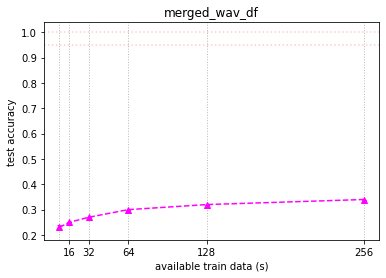

In [47]:
def show_inflection_point_graph(model_name, df, title, show_grid=True,color='#ff00ff',label=''):
    model_idx = np.where(df.index.to_numpy()==model_name)[0][0]
    res = df.iloc[model_idx]
    means = np.array([float(x.split('±')[0]) for x in res.to_numpy()])
    stds = np.array([float(x.split('±')[1]) for x in res.to_numpy()])
    x_axis = u_sorted_by_time_nts_ws if df.shape[1] == 11 else sorted_by_time_nts_ws
    n_secs = int(x_axis.max()+1)
    plt.errorbar(x_axis, means, stds, linestyle='--', marker='^',ecolor=color,elinewidth=1,capsize=2,color=color, label=label)
    if show_grid:
        plt.axhline(1, color='red',alpha=0.2,linestyle=':')
        plt.axhline(.95, color='red',alpha=0.2,linestyle=':')
    plt.xticks([2**i for i in range(4,9)])
    for i in np.arange(0,n_secs,0.25):
#         if int(i) == i:
#             plt.axvline(i, color='gray',alpha=0.25,linestyle=':')
        if show_grid and i in x_axis:
            plt.axvline(i, color='gray',alpha=0.55,linestyle=':',linewidth=1)
    
    plt.title(f'{title}')
    plt.xlabel('available train data (s)')
    plt.ylabel('test accuracy')

show_inflection_point_graph(models[0], df, 'merged_wav_df')

<ipython-input-50-9fcbebb059ce>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 4, 1+j )


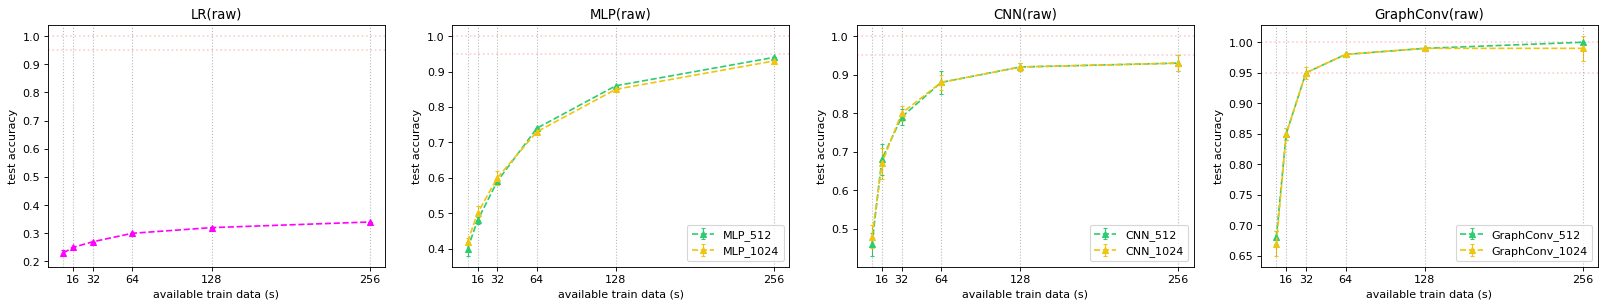

In [50]:
from matplotlib.pyplot import figure
colors = ['#2ecc71','#f1c40f','#e67e22','#3498db','#9b59b6','#34495e']

figure(figsize=(25, 4), dpi=80)
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.2, hspace=0)
for j, name in enumerate(model_names):
    if name =='LR':
        plt.subplot(1, 4, 1)
        show_inflection_point_graph(name, df, f'{name}(raw)')
#             plt.subplot(4, 1, 5)
#             show_inflection_point_graph(name, merged_df, f'{name} ({features[i]}) merged')
        continue
    for k, hc in enumerate(hidden_channels):
        plt.subplot(1, 4, 1+j )
        show_inflection_point_graph(f'{name}_{hc}', df, f'{name}(raw)',show_grid = True if k ==0 else False,color=colors[k],label=f'{name}_{hc}')
        plt.legend()
#             plt.subplot(4, 1, 5+j)
#             show_inflection_point_graph(f'{name}_{hc}', merged_df, f'{name} ({features[i]}) merged',show_grid = True if k ==0 else False,color=colors[k],label=f'{name}_{hc}')
#             plt.legend()
plt.show()
# plt.savefig(f'figures/results_plot.png')

### Get min amount of data required to train each model for 99% test acc and 95% test acc. Also get highest score with 1 train sample

In [51]:
model_names

['LR', 'MLP', 'CNN', 'GraphConv']

In [90]:
def get_min_amount(row):
    accs = np.array([float(r.split('±')[0]) for r in row.to_numpy()])
    acc_90s_indices = np.where(accs>=.90)[0]
    acc_90 = '-'
    if len(acc_90s_indices)>0:
        idx = acc_90s_indices[0]
        acc_90 = row[idx] +' '+ row.index[idx]
    acc_95s_indices = np.where(accs>=.95)[0]
    acc_95 = '-'
    if len(acc_95s_indices)>0:
        idx = acc_95s_indices[0]
        acc_95 = row[idx] +' '+ row.index[idx]
    acc_99s_indices = np.where(accs>=.99)[0]
    acc_99 = '-'
    if len(acc_99s_indices)>0:
        idx = acc_99s_indices[0]
        acc_99 = row[idx] +' '+ row.index[idx]
    return acc_90, acc_95, acc_99
        

In [91]:
indices = np.zeros(len(hidden_channels)*3+1).astype('str')
results = np.zeros(len(hidden_channels)*3+1).astype('object')
    # plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.2, hspace=0)
for j, name in enumerate(model_names):
    if name =='LR':
        acc_90, acc_95, acc_99 = get_min_amount(df.loc[name])
        if name not in indices:
            indices[0] = name
            results[0] = [acc_90, acc_95, acc_99]
        else:
            _acc_90, _acc_95, _acc_99 = results[0][0],results[0][1],results[0][2]
            if _acc_90.split('±')[0] < acc_90.split('±')[0]:
                results[0][0] = acc_90
            if _acc_95.split('±')[0] < acc_95.split('±')[0]:
                results[0][1] = acc_95
            if _acc_99.split('±')[0] < acc_99.split('±')[0]:
                results[0][2] = acc_99
        continue
    for k, hc in enumerate(hidden_channels):
        name_hc = f'{name}_{hc}'
        idx = (j-1) * len(hidden_channels) + 1 + k
        acc_90, acc_95, acc_99 = get_min_amount(df.loc[name_hc])
        if name_hc not in indices:
            indices[idx] = name_hc
            results[idx] = [acc_90, acc_95, acc_99]
        else:
            _acc_90, _acc_95, _acc_99 = results[0][0],results[0][1],results[0][2]
            if _acc_90.split('±')[0] < acc_90.split('±')[0]:
                results[0][0] = acc_90
            if _acc_95.split('±')[0] < acc_95.split('±')[0]:
                results[0][1] = acc_95
            if _acc_99.split('±')[0] < acc_99.split('±')[0]:
                results[0][2] = acc_99
#     break    

In [93]:
nine_zeros = [x[0] for x in results]
nine_fives = [x[1] for x in results]
nine_nines = [x[2] for x in results]

In [94]:
df = pd.DataFrame(
{"90" : nine_zeros,
"95" : nine_fives,
"99" : nine_nines},
index = df.index)

In [57]:
df

,95,99
LR,-,-
MLP_512,-,-
MLP_1024,-,-
CNN_512,-,-
CNN_1024,-,-
GraphConv_512,0.95±0.00 raw 0.5s x64,0.99±0.00 raw 0.5s x256
GraphConv_1024,0.95±0.01 raw 0.5s x64,0.99±0.00 raw 0.5s x256
